# Qubit-qumode tutorial

We assume one qumode is coupled to one qubit but the qubit space is not used explicitly in some cases.

## Prerequisite

Installation cells for Google Colab users.

In [1]:
!pip install qutip
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 87.9 MB/s eta 0:00:00


Import libaries.

In [2]:
import numpy as np
import qutip as qt
import scipy.optimize as sciopt

from functools import partial

In [3]:
import sys
import copy

In [4]:
import matplotlib.pyplot as plt

## Ansatz circuits

We use `QuTip` and follow ( qubit $\otimes$ qumode ) notation where applicable.

### Basics

In [5]:
def get_cvec_np(r, theta):
    r = np.array(r)
    theta = np.array(theta)
    return r * np.exp(1j * theta)

In [6]:
def qproj00():
    return qt.basis(2, 0).proj()

def qproj11():
    return qt.basis(2, 1).proj()

def qproj01():
    op = np.array([[0, 1], [0, 0]])
    return qt.Qobj(op)

def qproj10():
    op = np.array([[0, 0], [1, 0]])
    return qt.Qobj(op)

In [7]:
def qubit_rot(theta, phi):
    """
    R (theta, phi) = exp[ −i (theta/2) ( X cos(phi) + Y sin(phi) ) ].

    Arguments:
    theta, phi: rotation parameters
    """
    gen = ( qt.sigmax() * np.cos(phi) )
    gen += ( qt.sigmay() * np.sin(phi) )

    H = -1j * (theta / 2) * gen

    return H.expm()

### ECD-rotation

Qubit rotation with qumode echoed conditional displacement (ECD) operator ([reference](https://doi.org/10.1038/s41567-022-01776-9))

\begin{align*}
U (\beta, \theta, \phi)
&= ECD (\beta) \: \big[ R (\theta, \phi) \otimes I \big],
\\
R (\theta, \phi)
&= e^{ - i (\theta / 2) \big[ \cos(\phi) X + \sin(\phi) Y \big] },
\\
ECD (\beta)
&= |1 \rangle \langle 0| \otimes D (\beta / 2)  
+ |0 \rangle \langle 1| \otimes D (-\beta / 2),
\\
D (\beta)
&= e^{ \beta a^\dagger - \beta^* a }.
\end{align*}

In [8]:
def ecd_rot_op(beta, theta, phi, nfock):
    """
    ECD-rotation operator.

    Arguments:
    beta -- ECD parameter
    theta, phi -- rotation parameters
    nfock -- Fock cutoff
    """
    # ECD
    E2 = qt.tensor(qproj10(), qt.displace(nfock, beta/2))
    E2 += qt.tensor(qproj01(), qt.displace(nfock, -beta/2))

    # Rotation
    R2 = qt.tensor(qubit_rot(theta, phi), qt.qeye(nfock))

    return E2 * R2

Build the ansatz matrix of depth $N_d$

$$ \mathcal{U} (\vec{\beta}, \vec{\theta}, \vec{\phi})
= U (\beta_{N_d}, \theta_{N_d}, \phi_{N_d}) \cdots
U (\beta_1, \theta_1, \phi_1),
$$

where $\vec{\beta}, \vec{\theta}$, and $\vec{\phi}$ are $N_d$-dimensional vectors.

In [9]:
def unpack_params_ecd_rot(X):
    # Initialize
    dim = X.shape[0] // 4

    # Unpack
    beta_mag = X[:dim].copy()
    beta_arg = X[dim:2*dim].copy()
    theta = X[2*dim:3*dim].copy()
    phi = X[3*dim:4*dim].copy()

    return beta_mag, beta_arg, theta, phi

def pack_params_ecd_rot(beta_mag, beta_arg, theta, phi):
    # Initialize
    dim = beta_mag.shape[0]
    X = np.zeros((4 * dim,))

    # Pack
    X[:dim] = beta_mag.copy()
    X[dim:2*dim] = beta_arg.copy()
    X[2*dim:3*dim] = theta.copy()
    X[3*dim:4*dim] = phi.copy()

    return X

In [10]:
def ecd_rot_ansatz(bmagvec, bargvec, thetavec, phivec, nfock):
    """
    ECD-rotation ansatz.

    Arguments:
    bmagvec, bargvec -- ECD parameters
    thetavec, phivec -- rotation parameters
    nfock -- Fock cutoff
    """
    # Check
    if bmagvec.shape != bargvec.shape:
        raise ValueError("Dimensions of bmagvec and bargvec do not match.")
    betavec = get_cvec_np(bmagvec, bargvec)
    if betavec.shape != thetavec.shape:
        raise ValueError("Lengths of betavec and thetavec do not match.")
    if betavec.shape != phivec.shape:
        raise ValueError("Lengths of betavec and phivec do not match.")

    # Initialize
    ndepth = betavec.shape[0]
    uni = ecd_rot_op(betavec[0], thetavec[0], phivec[0], nfock)

    # Check
    if ndepth == 1:
        return uni

    # Loop through blocks
    for i in range(1, ndepth):
        new_uni = ecd_rot_op(betavec[i], thetavec[i], phivec[i], nfock)
        uni = ( new_uni * uni )

    return uni.full()

### SNAP-displacement

Selective number-dependent arbitray phase (SNAP) and displacement operator ([reference](https://doi.org/10.1103/PhysRevA.92.040303))

\begin{align*}
U (\alpha, \vec{\theta})
&= S (\vec{\theta}) \: D (\alpha),
\\
S (\vec{\theta})
&= \sum_{n = 0}^{L - 1} \: \exp ( i \: \theta_n ) \: |n \rangle \langle n|,
\\
D (\alpha)
&= e^{ \alpha \: ( a^\dagger - a ) }.
\end{align*}

In [11]:
def snap_disp_op(alpha, thetavec):
    """
    SNAP-displacement operator.

    Arguments:
    alpha -- displacement coefficient
    thetavec -- SNAP parameters
    """
    # Initialize
    nfock = thetavec.shape[0]

    # SNAP
    S2 = np.exp(1j * thetavec[0]) * qt.basis(nfock, 0).proj()
    for i in range(1, nfock):
        S2 += np.exp(1j * thetavec[i]) * qt.basis(nfock, i).proj()

    # Rotation
    D2 = qt.displace(nfock, alpha)

    return S2 * D2

Build the ansatz matrix of depth $N_d$

$$ \mathcal{U} (\vec{\alpha}, \bar{\theta})
= U (\alpha_{N_d}, \vec{\theta}_{N_d}) \cdots
U (\alpha_1, \vec{\theta}_1),
$$

where $\vec{\alpha}$ is an $N_d$-dimensional vector and
$ \bar{\theta}_{N_d \times L} $ is a matrix.


In [12]:
def unpack_params_snap_disp(X, nfock):
    # Initialize
    ndepth = X.shape[0] // (nfock + 1)

    # Unpack
    alpha = X[:ndepth].copy()
    d1 = ndepth * nfock
    theta = X[ndepth:ndepth+d1].reshape((ndepth, nfock))

    return alpha, theta

def pack_params_snap_disp(alpha, theta):
    # Initialize
    ndepth = alpha.shape[0]
    nfock = theta.shape[1]
    dim = (nfock + 1) * ndepth
    X = np.zeros((dim,))

    # Pack
    X[:ndepth] = alpha.copy()
    d1 = ndepth * nfock
    X[ndepth:ndepth+d1] = theta.reshape(-1)

    return X

In [13]:
def snap_disp_ansatz(alphavec, thetamat, nfock):
    """
    SNAP-displacement ansatz.

    Arguments:
    alphavec -- displacement parameters
    thetamat -- SNAP parameters
    nfock -- Fock cutoff
    """
    # Check
    if thetamat.shape[0] != alphavec.shape[0]:
        raise ValueError("Lengths of theta and alpha do not match.")
    if thetamat.shape[1] != nfock:
        raise ValueError("Incorrect nfock chosen.")

    # Initialize
    ndepth = thetamat.shape[0]
    uni = snap_disp_op(alphavec[0], thetamat[0, :])

    # Check
    if ndepth == 1:
        return uni

    # Loop through blocks
    for i in range(1, ndepth):
        new_uni = snap_disp_op(alphavec[i], thetamat[i, :])
        uni = ( new_uni * uni )

    return uni.full()

## Circuit synthesis for states

Let us denote $| \psi \rangle$ as our target qumode state  and $| \phi \rangle$ is the parametrized state.
If $| \phi \rangle$ is a qubit-qumode state, then the cost function is

$$ C
= 1 - | \langle \phi| 0, \psi \rangle |^2,
$$

and if $| \phi \rangle$ is a qumode state, then the cost function is

$$ C
= 1 - | \langle \phi| \psi \rangle |^2,
$$

where all the states are assumed normalized.

### ECD-rotation

In [14]:
def state_cost_fun_ecd_rot(Xvec, psi):
    """
    Loss function.

    Arguments:
    Xvec -- ansatz parameters
    psi -- target qubit-qumode state
    """
    # Unpack
    bmagvec, bargvec, thetavec, phivec = unpack_params_ecd_rot(Xvec)

    # ECD unitary
    nfock = psi.full().shape[0] // 2
    U = ecd_rot_ansatz(bmagvec, bargvec, thetavec, phivec, nfock)

    # |phi>
    vac = qt.basis(2*nfock, 0)
    phi = qt.Qobj(U) * vac

    # Overlap
    ov = phi.overlap(psi)

    return 1 - np.abs(ov**2)

In [15]:
def state_ecd_rot_opt(state, ndepth, maxiter=100, method='COBYLA', verb=0, \
                      threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using SciPy-based methods.

    Arguments:
    state -- target qumode state in QuTip
    ndepth -- ansatz circuit depth
    maxiter -- maximum number of iterations
    method -- optimization method
    verb -- print additional things or not
    threshold -- error tolerance
    Xvec -- optional initial guesses
    """
    # Qubit-qumode matrix
    FullPsi = qt.Qobj( qt.tensor(qt.basis(2, 0), state).full() )

    # Bound parameters
    beta_mag_min = 0.0
    beta_mag_max = 10.0
    beta_arg_min = 0.0
    beta_arg_max = 2 * np.pi
    theta_min = 0.0
    theta_max = np.pi
    phi_min = 0.0
    phi_max = 2 * np.pi

    # Define bounds
    bounds = []
    for _ in range(ndepth):
        bounds.append([beta_mag_min, beta_mag_max])
    for _ in range(ndepth):
        bounds.append([beta_arg_min, beta_arg_max])
    for _ in range(ndepth):
        bounds.append([theta_min, theta_max])
    for _ in range(ndepth):
        bounds.append([phi_min, phi_max])
    bounds = np.array(bounds)

    # Guess
    if len(Xvec) == 0:
        beta_mag = np.random.uniform(0, 3, size=ndepth)
        beta_arg = np.random.uniform(0, np.pi, size=ndepth)
        theta = np.random.uniform(0, np.pi, size=ndepth)
        phi = np.random.uniform(0, np.pi, size=ndepth)
        Xvec = pack_params_ecd_rot(beta_mag, beta_arg, theta, phi)

    # Loss function
    obj_fun = partial(state_cost_fun_ecd_rot, psi=FullPsi)

    # Intermediate values
    iteration_step = 0
    print_freq = 10
    def callback(xk):
        nonlocal iteration_step
        iteration_step += 1
        if verb == 1 and (iteration_step % print_freq == 0):
            print("-------------------")
            print(f"iter: {iteration_step}")
            print(f"fval: {obj_fun(xk)}")

    # SciPy options
    options = {'disp': True, 'maxiter': maxiter}

    # Optimize
    if method == 'COBYLA':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'Powell':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'CG':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'BFGS':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'L-BFGS-B':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'TNC':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 bounds=bounds, tol=threshold, callback=callback)
    elif method == 'trust-constr':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    else:
        result = sciopt.minimize(obj_fun, Xvec, method='COBYLA', bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)

    return result.fun, result.x

### SNAP-displacement

In [16]:
def state_cost_fun_snap_disp(Xvec, psi):
    """
    Loss function.

    Arguments:
    Xvec -- ansatz parameters
    psi -- target qumode state
    """
    # Unpack
    nfock = psi.full().shape[0]
    alphavec, thetamat = unpack_params_snap_disp(Xvec, nfock)

    # ECD unitary
    U = snap_disp_ansatz(alphavec, thetamat, nfock)

    # |phi>
    vac = qt.basis(nfock, 0)
    phi = qt.Qobj(U) * vac

    # Overlap
    ov = phi.overlap(psi)

    return 1 - np.abs(ov**2)

In [17]:
def state_snap_disp_opt(state, ndepth, maxiter=100, method='COBYLA', verb=0, \
                        threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using SciPy-based methods.

    Arguments:
    state -- target qumode state in QuTip
    ndepth -- ansatz circuit depth
    maxiter -- maximum number of iterations
    method -- optimization method
    verb -- print additional things or not
    threshold -- error tolerance
    Xvec -- optional initial guesses
    """
    # Initialize
    nfock = state.full().shape[0]

    # Bound parameters
    alpha_min = 0.0
    alpha_max = 10.0
    theta_min = 0.0
    theta_max = np.pi

    # Define bounds
    bounds = []
    for _ in range(ndepth):
        bounds.append([alpha_min, alpha_max])
    for _ in range(ndepth * nfock):
        bounds.append([theta_min, theta_max])
    bounds = np.array(bounds)

    # Guess
    if len(Xvec) == 0:
        alpha = np.random.uniform(0, 3, size=ndepth)
        theta = np.random.uniform(0, np.pi, size=(ndepth, nfock))
        Xvec = pack_params_snap_disp(alpha, theta)

    # Loss function
    obj_fun = partial(state_cost_fun_snap_disp, psi=state)

    # Intermediate values
    iteration_step = 0
    print_freq = 10
    def callback(xk):
        nonlocal iteration_step
        iteration_step += 1
        if verb == 1 and (iteration_step % print_freq == 0):
            print("-------------------")
            print(f"iter: {iteration_step}")
            print(f"fval: {obj_fun(xk)}")

    # SciPy options
    options = {'disp': True, 'maxiter': maxiter}

    # Optimize
    if method == 'COBYLA':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'Powell':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'CG':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'BFGS':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'L-BFGS-B':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'TNC':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 bounds=bounds, tol=threshold, callback=callback)
    elif method == 'trust-constr':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    else:
        result = sciopt.minimize(obj_fun, Xvec, method='COBYLA', bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)

    return result.fun, result.x

### Wrapper

In [18]:
def state_qumode_opt(state, ndepth, atype='ecd-rot', budget=100, method='COBYLA', \
                     verb=0, threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using various optimizers.

    Arguments:
    state -- target qumode state in QuTip
    atype -- type of ansatz
    ndepth -- ansatz circuit depth
    budget -- maximum number of iterations
    method -- optimization method
    threshold -- error tolerance
    Xvec -- optional initial guess
    """
    # Method library
    sc_tuple = ('COBYLA', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'trust-constr')

    # Optimize
    if atype == 'snap-disp':
        # SNAP-displacement
        if method in sc_tuple:
            loss, Xvec = state_snap_disp_opt(state, ndepth, maxiter=budget, \
                                             method=method, verb=verb, \
                                             threshold=threshold, Xvec=Xvec)
        else:
            print(f"Error: method not found")
            sys.exit(1)
    else:
        # ECD-rotation
        if method in sc_tuple:
            loss, Xvec = state_ecd_rot_opt(state, ndepth, maxiter=budget, \
                                           method=method, verb=verb, \
                                           threshold=threshold, Xvec=Xvec)
        else:
            print(f"Error: method not found")
            sys.exit(1)

    return loss, Xvec

## Circuit synthesis for operators

Let us denote $V_T$ as our target qumode matrix and $U$ is the parametrized matrix.
The cost function is

$$ C
= \frac{1}{L^2} \: \sum_{n, m = 0}^{L - 1} \:
| V_{n, m} - U_{n, m} |^2,
$$

where $L$ is the qumode Fock cutoff.
If $U$ is a qubit-qumode circuit then

\begin{align*}
V_{n, m}
&= \langle 0, n| ( I \otimes V_T ) | 0, m \rangle,
\\
U_{n, m}
&= \langle 0, n| U | 0, m \rangle,
\end{align*}
and if $U$ is a qumode circuit then

\begin{align*}
V_{n, m}
&= \langle n| V_T | m \rangle,
\\
U_{n, m}
&= \langle n| U | m \rangle.
\end{align*}

### Basics

In [19]:
def op_trans_qubit_cavity(op, n, m):
    """
    Compute <0, n| O |0, m>.

    Arguments:
    op -- Operator matrix
    n -- Fock level
    """
    # Check
    L = op.shape[0] // 2
    if n > L:
        raise ValueError("n > L.")
    if m > L:
        raise ValueError("m > L.")

    # |0, n> and |0, m>
    state1 = qt.tensor(qt.basis(2, 0), qt.basis(L, n)).full()
    state2 = qt.tensor(qt.basis(2, 0), qt.basis(L, m)).full()

    # <0, n| O |0, m>
    t1 = np.matmul(op, state2)
    ov = np.dot(np.conj(state1).T, t1)

    return np.squeeze(ov)

In [20]:
def op_trans_only_cavity(op, n, m):
    """
    Compute <n| O |m>.

    Arguments:
    op -- Operator matrix
    n -- Fock level
    """
    # Check
    L = op.shape[0]
    if n > L:
        raise ValueError("n > L.")
    if m > L:
        raise ValueError("m > L.")

    # |n> and |m>
    state1 = qt.basis(L, n).full()
    state2 = qt.basis(L, m).full()

    # <n| O |m>
    t1 = np.matmul(op, state2)
    ov = np.dot(np.conj(state1).T, t1)

    return np.squeeze(ov)

### ECD-rotation

In [21]:
def op_cost_fun_ecd_rot(Xvec, V):
    """
    Loss function.

    Arguments:
    Xvec -- ansatz parameters
    V -- target qubit-qumode operator
    """
    # Unpack
    bmagvec, bargvec, thetavec, phivec = unpack_params_ecd_rot(Xvec)

    # ECD unitary
    nfock = V.shape[0] // 2
    U = ecd_rot_ansatz(bmagvec, bargvec, thetavec, phivec, nfock)

    # Cost function
    ov = 0.0
    for j in range(nfock):
        for k in range(nfock):
            t0 = op_trans_qubit_cavity(V, j, k)
            t1 = op_trans_qubit_cavity(U, j, k)
            ov += np.abs( t0 - t1 )**2

    return ov / (nfock**2)

In [22]:
def op_ecd_rot_opt(V, ndepth, maxiter=100, method='COBYLA', verb=0, \
                   threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using SciPy-based methods.

    Arguments:
    V -- target qumode matrix in QuTip
    ndepth -- ansatz circuit depth
    maxiter -- maximum number of iterations
    method -- optimization method
    verb -- print additional things or not
    threshold -- error tolerance
    Xvec -- optional initial guesses
    """
    # Qubit-qumode matrix
    FullV = qt.tensor(qt.qeye(2), V).full()

    # Bound parameters
    beta_mag_min = 0.0
    beta_mag_max = 10.0
    beta_arg_min = 0.0
    beta_arg_max = 2 * np.pi
    theta_min = 0.0
    theta_max = np.pi
    phi_min = 0.0
    phi_max = 2 * np.pi

    # Define bounds
    bounds = []
    for _ in range(ndepth):
        bounds.append([beta_mag_min, beta_mag_max])
    for _ in range(ndepth):
        bounds.append([beta_arg_min, beta_arg_max])
    for _ in range(ndepth):
        bounds.append([theta_min, theta_max])
    for _ in range(ndepth):
        bounds.append([phi_min, phi_max])
    bounds = np.array(bounds)

    # Guess
    if len(Xvec) == 0:
        beta_mag = np.random.uniform(0, 3, size=ndepth)
        beta_arg = np.random.uniform(0, np.pi, size=ndepth)
        theta = np.random.uniform(0, np.pi, size=ndepth)
        phi = np.random.uniform(0, np.pi, size=ndepth)
        Xvec = pack_params_ecd_rot(beta_mag, beta_arg, theta, phi)

    # Loss function
    obj_fun = partial(op_cost_fun_ecd_rot, V=FullV)

    # Intermediate values
    iteration_step = 0
    print_freq = 10
    def callback(xk):
        nonlocal iteration_step
        iteration_step += 1
        if verb == 1 and (iteration_step % print_freq == 0):
            print("-------------------")
            print(f"iter: {iteration_step}")
            print(f"fval: {obj_fun(xk)}")

    # SciPy options
    options = {'disp': True, 'maxiter': maxiter}

    # Optimize
    if method == 'COBYLA':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'Powell':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'CG':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'BFGS':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'L-BFGS-B':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'TNC':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 bounds=bounds, tol=threshold, callback=callback)
    elif method == 'trust-constr':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    else:
        result = sciopt.minimize(obj_fun, Xvec, method='COBYLA', bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)

    return result.fun, result.x

### SNAP-displacement

In [23]:
def op_cost_fun_snap_disp(Xvec, V):
    """
    Loss function.

    Arguments:
    Xvec -- ansatz parameters
    V -- target qumode operator
    """
    # Unpack
    nfock = V.shape[0]
    alphavec, thetamat = unpack_params_snap_disp(Xvec, nfock)

    # ECD unitary
    U = snap_disp_ansatz(alphavec, thetamat, nfock)

    # Cost function
    ov = 0.0
    for j in range(nfock):
        for k in range(nfock):
            t0 = op_trans_only_cavity(V, j, k)
            t1 = op_trans_only_cavity(U, j, k)
            ov += np.abs( t0 - t1 )**2

    return ov / (nfock**2)

In [24]:
def op_snap_disp_opt(V, ndepth, maxiter=100, method='COBYLA', verb=0, \
                     threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using SciPy-based methods.

    Arguments:
    V -- target qumode matrix in QuTip
    ndepth -- ansatz circuit depth
    maxiter -- maximum number of iterations
    method -- optimization method
    verb -- print additional things or not
    threshold -- error tolerance
    Xvec -- optional initial guesses
    """
    # Qumode matrix
    FullV = V.full()
    nfock = FullV.shape[0]

    # Bound parameters
    alpha_min = 0.0
    alpha_max = 10.0
    theta_min = 0.0
    theta_max = np.pi

    # Define bounds
    bounds = []
    for _ in range(ndepth):
        bounds.append([alpha_min, alpha_max])
    for _ in range(ndepth * nfock):
        bounds.append([theta_min, theta_max])
    bounds = np.array(bounds)

    # Guess
    if len(Xvec) == 0:
        alpha = np.random.uniform(0, 3, size=ndepth)
        theta = np.random.uniform(0, np.pi, size=(ndepth, nfock))
        Xvec = pack_params_snap_disp(alpha, theta)

    # Loss function
    obj_fun = partial(op_cost_fun_snap_disp, V=FullV)

    # Intermediate values
    iteration_step = 0
    print_freq = 10
    def callback(xk):
        nonlocal iteration_step
        iteration_step += 1
        if verb == 1 and (iteration_step % print_freq == 0):
            print("-------------------")
            print(f"iter: {iteration_step}")
            print(f"fval: {obj_fun(xk)}")

    # SciPy options
    options = {'disp': True, 'maxiter': maxiter}

    # Optimize
    if method == 'COBYLA':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'Powell':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'CG':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'BFGS':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'L-BFGS-B':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'TNC':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 bounds=bounds, tol=threshold, callback=callback)
    elif method == 'trust-constr':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    else:
        result = sciopt.minimize(obj_fun, Xvec, method='COBYLA', bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)

    return result.fun, result.x

### Wrapper

In [25]:
def op_qumode_opt(V, ndepth, atype='ecd-rot', budget=100, method='COBYLA', \
                  verb=0, threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using various optimizers.

    Arguments:
    V -- target qumode matrix in QuTip
    atype -- type of ansatz
    ndepth -- ansatz circuit depth
    budget -- maximum number of iterations
    method -- optimization method
    threshold -- error tolerance
    Xvec -- optional initial guess
    """
    # Method library
    sc_tuple = ('COBYLA', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'trust-constr')

    # Optimize
    if atype == 'snap-disp':
        # SNAP-displacement
        if method in sc_tuple:
            loss, Xvec = op_snap_disp_opt(V, ndepth, maxiter=budget, \
                                          method=method, verb=verb, \
                                          threshold=threshold, Xvec=Xvec)
        else:
            print(f"Error: method not found")
            sys.exit(1)
    else:
        # ECD-rotation
        if method in sc_tuple:
            loss, Xvec = op_ecd_rot_opt(V, ndepth, maxiter=budget, \
                                        method=method, verb=verb, \
                                        threshold=threshold, Xvec=Xvec)
        else:
            print(f"Error: method not found")
            sys.exit(1)

    return loss, Xvec

## Visualization

In [26]:
def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    # Domain parameter for Wigner function plots
    l = 8.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

In [27]:
def state_vis(phi, Xvec, nfock, atype='ecd-rot', title=None):
    # State
    if atype == 'snap-disp':
        alphavec, thetamat = unpack_params_snap_disp(Xvec, nfock)
        U = snap_disp_ansatz(alphavec, thetamat, nfock)
        vac = qt.basis(nfock, 0)
        psi = qt.Qobj(U) * vac
    else:
        bmagvec, bargvec, thetavec, phivec = unpack_params_ecd_rot(Xvec)
        U = ecd_rot_ansatz(bmagvec, bargvec, thetavec, phivec, nfock)
        vac = qt.basis(2 * nfock, 0)
        psi = qt.Qobj(U) * vac

    # Wigner function
    psi_dm = psi.proj().full()
    phi_dm = phi.proj().full()

    fig = plt.figure()
    ax1 = fig.add_subplot(121, projection="3d")
    X, P, W = wigner(phi_dm)
    ax1.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
    ax1.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
    ax1.set_axis_off()
    ax1.set_title("Target State")

    ax2 = fig.add_subplot(122, projection="3d")
    X, P, W = wigner(psi_dm)
    ax2.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
    ax2.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
    ax2.set_axis_off()
    ax2.set_title("Optimized State")

    # Optional global title
    if title:
        fig.suptitle(title, fontsize=16)
        fig.subplots_adjust(top=0.88)

    fig.tight_layout()
    fig.show()

## Explore

Let us apply our tools for preparing the target qumode state $| 3 \rangle$.

In [ ]:
# Target qumode state is |3> with Fock cutoff L = 10
nf1 = 10
target_state = qt.basis(nf1, 3)

# Optimization with ECD-rotation
nd_ecd1 = 8
loss_ecd1, Xvec_ecd1 = state_qumode_opt(target_state, nd_ecd1, atype='ecd-rot',
                                        budget=500, method='BFGS',
                                        verb=1, threshold=1e-12)

print("=============ECD-rot state=============")

print(f"Loss value: {loss_ecd1}")
print(f"Number of circuit blocks: {nd_ecd1}")
print(f"Number of parameters: {len(Xvec_ecd1)}")

print("=======================================")

# Optimization with SNAP-displacement
nd_snap1 = 3
loss_snap1, Xvec_snap1 = state_qumode_opt(target_state, nd_snap1, atype='snap-disp',
                                          budget=500, method='BFGS',
                                          verb=1, threshold=1e-12)

print("=============SNAP-disp state=============")

print(f"Loss value: {loss_snap1}")
print(f"Number of circuit blocks: {nd_snap1}")
print(f"Number of parameters: {len(Xvec_snap1)}")

print("=======================================")

-------------------
iter: 10
fval: 0.28147975220005805
-------------------
iter: 20
fval: 0.0951110071708342
-------------------
iter: 30
fval: 0.02221455780545456
-------------------
iter: 40
fval: 0.00770520140315345
-------------------
iter: 50
fval: 0.006423368081583503
-------------------
iter: 60
fval: 0.0018882640682306162
-------------------
iter: 70
fval: 0.0016334920612159909
-------------------
iter: 80
fval: 0.0016329679051247936
-------------------
iter: 90
fval: 0.0016329670671385577
-------------------
iter: 100
fval: 0.0016322044545348247
-------------------
iter: 110
fval: 0.0016213021486206625
-------------------
iter: 120
fval: 0.0013121429044191668
-------------------
iter: 130
fval: 0.0012742369216700578
-------------------
iter: 140
fval: 0.0012332734877444906
-------------------
iter: 150
fval: 0.0012146845753002733
-------------------
iter: 160
fval: 0.001161897813813706
-------------------
iter: 170
fval: 0.0004431127314773464
-------------------
iter: 180
fval

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 233
         Function evaluations: 10010
         Gradient evaluations: 303
=============ECD-rot state=============
Loss value: 2.531308496145357e-14
Number of circuit blocks: 8
Number of parameters: 32
-------------------
iter: 10
fval: 0.2994326623861838
-------------------
iter: 20
fval: 0.08717491481043671
-------------------
iter: 30
fval: 0.009947973277349309
-------------------
iter: 40
fval: 0.000664433111874807
-------------------
iter: 50
fval: 0.0003763205684049753
-------------------
iter: 60
fval: 7.587781003726146e-05
-------------------
iter: 70
fval: 6.699803692944428e-06
-------------------
iter: 80
fval: 1.2282069405955554e-07
         Current function value: 0.000000
         Iterations: 87
         Function evaluations: 3344
         Gradient evaluations: 98
=============SNAP-disp state=============
Loss value: 1.4210854715202004e-14
Number of circuit blocks: 3
Number of parameters: 33


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


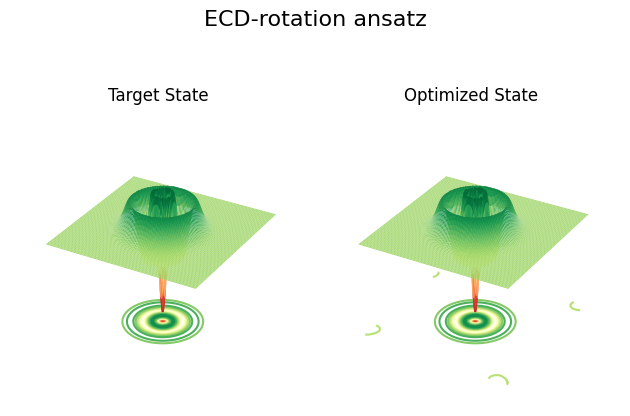

In [ ]:
state_vis(target_state, Xvec_ecd1, nf1, atype='ecd-rot', title='ECD-rotation ansatz')

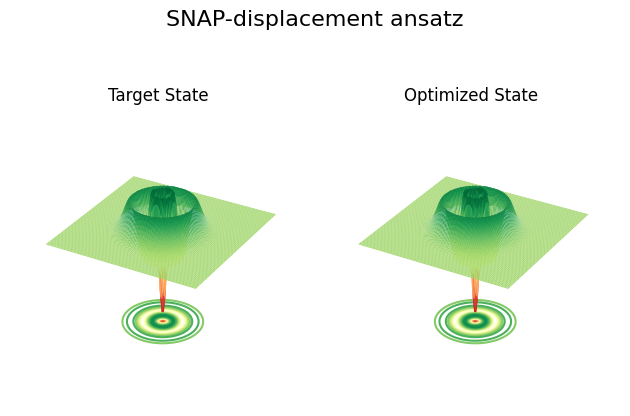

In [ ]:
state_vis(target_state, Xvec_snap1, nf1, atype='snap-disp', title='SNAP-displacement ansatz')

Let us apply our tools for representing the target unitary operator $U (\theta) = e^{i \theta \: X_1 Z_2}$ using qumode gates.
Here, we are mapping a two-qubit operator to a qumode operator with Fock cutoff $L = 2^2 = 4$.

In [ ]:
# Target operator is exp(2i X1 Z2)
target_op1 = ( 1j * 2 * qt.tensor( qt.sigmax(), qt.sigmaz() ) ).expm()
target_op1 = qt.Qobj( target_op1.full() )

# Optimization with ECD-rotation
nd_ecd2 = 10
loss_ecd2, Xvec_ecd2 = op_qumode_opt(target_op1, nd_ecd2, atype='ecd-rot',
                                     budget=200, method='BFGS',
                                     verb=1, threshold=1e-12)

print("=============ECD-rot operator=============")

print(f"Loss value: {loss_ecd2}")
print(f"Number of circuit blocks: {nd_ecd2}")
print(f"Number of parameters: {len(Xvec_ecd2)}")

print("=======================================")

# Optimization with SNAP-displacement
nd_snap2 = 8
loss_snap2, Xvec_snap2 = op_qumode_opt(target_op1, nd_snap2, atype='snap-disp',
                                       budget=200, method='BFGS',
                                       verb=1, threshold=1e-12)

print("=============SNAP-disp operator=============")

print(f"Loss value: {loss_snap2}")
print(f"Number of circuit blocks: {nd_snap2}")
print(f"Number of parameters: {len(Xvec_snap2)}")

print("=======================================")

-------------------
iter: 10
fval: 0.023013271812700457
-------------------
iter: 20
fval: 0.00894236906452658
-------------------
iter: 30
fval: 0.00528295834934706
-------------------
iter: 40
fval: 0.0042035177926940046
-------------------
iter: 50
fval: 0.003712767609902876
-------------------
iter: 60
fval: 0.0029676923683038953
-------------------
iter: 70
fval: 0.0021195783157235064
-------------------
iter: 80
fval: 0.0013244670352251804
-------------------
iter: 90
fval: 0.0008578970566657728
-------------------
iter: 100
fval: 0.0006582200454996381
-------------------
iter: 110
fval: 0.0005854480639997669
-------------------
iter: 120
fval: 0.0005398686120883006
-------------------
iter: 130
fval: 0.0005020205661383159
-------------------
iter: 140
fval: 0.00046991205349845557
-------------------
iter: 150
fval: 0.00045579495265849607
-------------------
iter: 160
fval: 0.0004385005185217721
-------------------
iter: 170
fval: 0.00040348106926028487
-------------------
iter: 

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


-------------------
iter: 10
fval: 0.0019316351626621475
-------------------
iter: 20
fval: 1.337759005722404e-06
-------------------
iter: 30
fval: 5.7343478054807815e-11
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 3169
         Gradient evaluations: 77
=============SNAP-disp operator=============
Loss value: 3.692728418493851e-16
Number of circuit blocks: 8
Number of parameters: 40


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Let us apply our tools for representing a target qumode unitary operator called the cubic phase gate,
$ U (\theta) = e^{i \theta \: \hat{x}^3} $, where $\hat{x}$ is the position operator.
This is a non-Gaussian gate and is non-trivial to implement natively with qumode hardware.
This is why we will decompose them using our universal qumode building block gates.
As we will see below, SNAP-displacement is more efficient than ECD-rotation gates for parametrizing target operators.

In [28]:
# Target qumode operator is the cubic phase gate exp(-0.3 i x^3)
# where x is position operator with Fock cutoff = 8
target_op2 = ( -1j * 0.3 * qt.position(8) * qt.position(8) * qt.position(8) ).expm()

# Optimization with ECD-rotation
nd_ecd3 = 14
loss_ecd3, Xvec_ecd3 = op_qumode_opt(target_op2, nd_ecd3, atype='ecd-rot',
                                     budget=200, method='BFGS',
                                     verb=1, threshold=1e-12)

print("=============ECD-rot operator=============")

print(f"Loss value: {loss_ecd3}")
print(f"Number of circuit blocks: {nd_ecd3}")
print(f"Number of parameters: {len(Xvec_ecd3)}")

print("=======================================")

# Optimization with SNAP-displacement
nd_snap3 = 6
loss_snap3, Xvec_snap3 = op_qumode_opt(target_op2, nd_snap3, atype='snap-disp',
                                       budget=200, method='BFGS',
                                       verb=1, threshold=1e-12)

print("=============SNAP-disp operator=============")

print(f"Loss value: {loss_snap3}")
print(f"Number of circuit blocks: {nd_snap3}")
print(f"Number of parameters: {len(Xvec_snap3)}")

print("=======================================")

-------------------
iter: 10
fval: 0.09068884299387889
-------------------
iter: 20
fval: 0.06078184032408868
-------------------
iter: 30
fval: 0.04967925934354427
-------------------
iter: 40
fval: 0.04111110864671993
-------------------
iter: 50
fval: 0.034295426470233675
-------------------
iter: 60
fval: 0.03171998233763881
-------------------
iter: 70
fval: 0.030885782479959815
-------------------
iter: 80
fval: 0.029275146184492968
-------------------
iter: 90
fval: 0.025530341823645678
-------------------
iter: 100
fval: 0.024397787976324678
-------------------
iter: 110
fval: 0.02419469679335032
-------------------
iter: 120
fval: 0.02405880930519829
-------------------
iter: 130
fval: 0.023989477970000662
-------------------
iter: 140
fval: 0.023930005388206596
-------------------
iter: 150
fval: 0.02382086080605949
-------------------
iter: 160
fval: 0.023766045399005918
-------------------
iter: 170
fval: 0.02374871102242025
-------------------
iter: 180
fval: 0.02373903029

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


-------------------
iter: 10
fval: 0.14236735556349486
-------------------
iter: 20
fval: 0.07522442905436832
-------------------
iter: 30
fval: 0.05994996946579557
-------------------
iter: 40
fval: 0.0454559435807916
-------------------
iter: 50
fval: 0.037206105631214945
-------------------
iter: 60
fval: 0.030083287116455207
-------------------
iter: 70
fval: 0.027661700524312337
-------------------
iter: 80
fval: 0.026042181019918204
-------------------
iter: 90
fval: 0.024775196131430543
-------------------
iter: 100
fval: 0.021415285821779033
-------------------
iter: 110
fval: 0.016213972012363517
-------------------
iter: 120
fval: 0.013399467635791088
-------------------
iter: 130
fval: 0.010894756514102709
-------------------
iter: 140
fval: 0.009859679728600936
-------------------
iter: 150
fval: 0.009054117593024345
-------------------
iter: 160
fval: 0.008411993280806463
-------------------
iter: 170
fval: 0.008070960244527626
-------------------
iter: 180
fval: 0.0078120